# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "julia"
ln1 = "cuvelier"
fn2 = "marius"
ln2 = "ortega"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_cuvelier_julia_and_ortega_marius.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

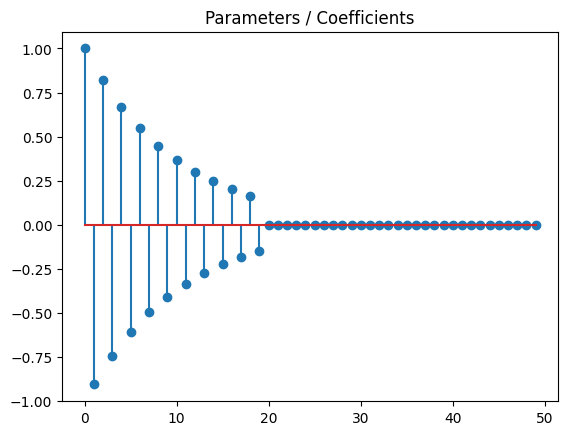

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [6]:
A, b = simu_linreg(coefs)
#A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

#### Prox-L1

To find $prox_{L1}$ we have to solve the following problem :
$$
\text{prox}_{(\lambda \vert\vert z \vert\vert_1)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \Vert z \Vert_1 \right\} \\
$$

We can reformulate the problem by writting the optimal condition : 
$$
0 \in \nabla \left( \frac{1}{2} \Vert x - z\Vert_2^2 \right) + \partial (\lambda \Vert z\Vert_1) \Leftrightarrow 0 \in z - x + \lambda\partial\Vert z\Vert_1
$$

Let's rewrite the expression at the optimum $z^*$ :

$$
0 = z^* - x + \lambda\partial\Vert z^*\Vert_1 = z^* - x + \lambda sign(z^*) \Leftrightarrow z^* = x - sign(z^*) \\
$$

We substituate $z^*$ in the expression of the proximal operator :
$$
sign(z^*) = sign(x), \forall x, \lambda \Rightarrow z^* = x - sign(x)
$$

From there, we express the proximal of $L_1 norm$ : 

$$
\begin{equation} \tag{1}
  \text{prox}_{(\lambda \frac{1}{2} \vert\vert z \vert\vert_2^2)}(x) = z^* = 
    \begin{cases}
      0 & \text{if }\vert x \vert \le \lambda\\
      x-\lambda sign(x) & \text{if } \vert x \vert > \lambda\\
    \end{cases}      
    \Rightarrow prox_{\lambda \vert\vert z \vert\vert_1}(x) = sign(x) \max(\vert x \vert - \lambda, 0)
\end{equation}
$$

#### Prox-L2

To find $prox_{L2}$ we have to solve the following problem :
$$
\text{prox}_{(\lambda \frac{1}{2} \vert\vert z \vert\vert_2^2)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \frac{1}{2} \Vert z \Vert_2^2 \right\} \\
$$

We can reformulate the problem by writting the optimal condition :
$$
0 = \nabla \left( \frac{1}{2} \Vert x - z^*\Vert_2^2 \right) + \partial (\lambda \frac{1}{2} \Vert z^*\Vert_2^2) \Leftrightarrow 0 = z^* - x + \lambda z^* \Leftrightarrow z^* = \frac{x}{1+\lambda}
$$

Then, the proximal operator of $L_2norm$ is given by :
$$
\begin{equation} \tag{2}
\text{prox}_{(\lambda \frac{1}{2} \vert\vert z \vert\vert_2^2)}(x) = z^* = \frac{x}{1+\lambda}
\end{equation}
$$

In [7]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    prox = np.sign(x)*np.maximum(np.abs(x)-lmbd, 0)
    return prox # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    x = lmbd * norm(x, ord=1)
    return x # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    prox = x/(1 + lmbd)
    return prox # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    x = (1/2)*lmbd * norm(x, ord=2)**2
    return x # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

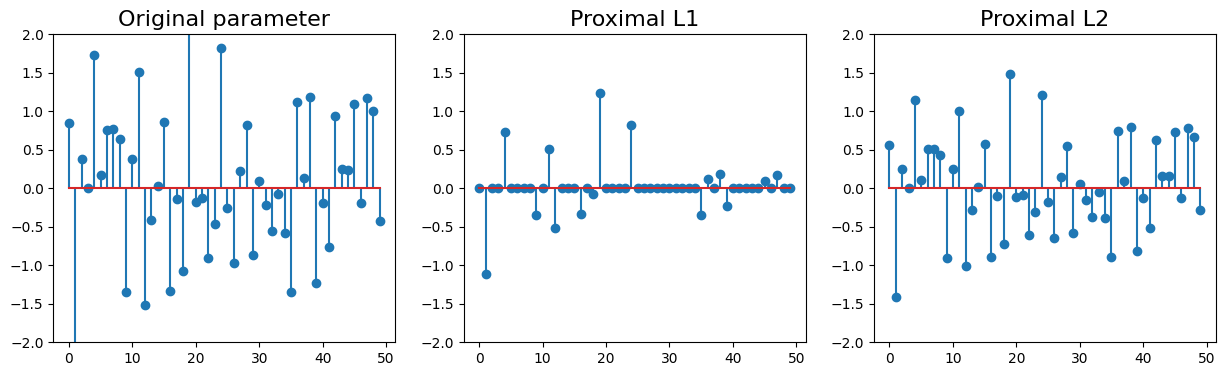

In [8]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

#### L1-norm

We notice that all values that are greater than lambda are scaled down by the value of lambda and the other (i.e. less important) parameters are put to 0. The L1 regulariation promotes sparcity which induces feature selection and helps accelerating computation. 

#### L2-norm squared

L2-squared normalization tends to scale down all components without promoting sparsity like L1 normalization. It smoothes parameters' distribution due to its quadratic term. 

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

Let's start by computing the gradient of $f$ for both cases :

#### Linear regression

$$
\begin{align*}

\nabla f(x) &= \frac{1}{2n} \nabla \Vert b - Ax \Vert_2^2 \\
&= \frac{1}{n} A^T (b - Ax) 

\end{align*}
$$

#### Logistic regression

$$

\begin{align*}
\nabla f(x) &= \frac{1}{n} \nabla \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)) \\
            &= \frac{1}{n} \sum_{i=1}^n \frac{-b_i a_i \exp(-b_i a_i^\top x)}{1 + \exp(-b_i a_i^\top x)} = \frac{1}{n} \sum_{i=1}^n -b_ia_i(1 - \sigma(b_i a_i^\top x)), \text{because  } 1-\sigma(z) = \frac{e^{-z}}{1+e^{-z}} \\
\end{align*}
$$

In [9]:
def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    loss = (1/(2*n_samples)) * norm(b - A@x, ord=2)**2
    return loss

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    grad = 1/n_samples * A.T @ (A@x-b)
    return grad

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    loss = np.mean(np.log(1 + np.exp(-b * A.dot(x))))
    return loss

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    #grad = np.mean((-b * A) * (1-sigmoid(-b * A.dot(x))), axis=1)
    n = len(b)
    sigmoid_x = 1/(1 + np.exp(-A.dot(x)))
    grad = -(1/n) * A.T.dot(b * (1 - sigmoid_x))
    return grad

# TO BE COMPLETED

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

We want to compute Lipschitz constants for both linear and logistic regression losses : 

- #### For linear regression :
    $$
    f(x) = \frac{1}{2 n} \| b - A x \|_2^2 \Rightarrow \nabla f(x) = \frac{1}{n} A^\top(Ax-b) \Rightarrow \nabla^2 f(x) = \frac{1}{n} A^\top A
    $$
    
    By definition, of the Lipschitz constant for linear regression (proved in class) :
    $$
    L_{linreg} = \frac{1}{n}\lambda_{max}(A^\top A)
    $$ 
    Thus, we can compute the Lipschitz constant using the operator norm of the matrix $X$ :
    $$
    L_{linreg} = \frac{1}{n}\lambda_{max}(A^{\top} A) = \frac{1}{n}\sigma_{max}^2(A) = \frac{1}{n}\Vert A \Vert_{op}^2
    $$

- #### For logistic regression :

    Here, we will use 2nd order smoothness definition :
    $$
    \nabla^2 f(x) \preceq L_{linreg}I_d
    $$

    We first compute the Hessian of the logistic regression loss :
    $$
    \begin{align*}
    
    & f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)) \\ 
    & \nabla f(x) = \frac{1}{n} \sum_{i=1}^n \frac{-b_i a_i \exp(-b_i a_i^\top x)}{1 + \exp(-b_i a_i^\top x)} = \frac{1}{n} \sum_{i=1}^n \frac{b_i a_i}{1 + \exp(b_i a_i^\top x)} \\
    & \nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n \frac{b_i^2 a_i a_i^\top \exp(b_i a_i^\top x)}{(1 + \exp(b_i a_i^\top x))^2} = \frac{1}{n} \sum_{i=1}^n b_i^2 \sigma(b_ia_i^\top x)(1-\sigma(b_i a_i^\top x))a_i a_i^\top\preceq \frac{1}{4n} \sum_{i=1}^n a_i a_i^T = \frac{1}{4n} A^\top A
    
    \end{align*}
    $$

    From there, we can retrieve the Lipschitz constant for logistic regression :
    $$
    \frac{1}{4n} A^\top A \preceq L_{logreg} I_d \Rightarrow L_{logreg} = \frac{1}{4n} \lambda_{max}(A^\top A) = \frac{1}{4n} \sigma^2_{max}(A) = \frac{1}{4n} \Vert A \Vert_{op}^2
    $$

In [10]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    return (1/n_samples) * norm(A, ord=2)**2

# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    return (1/4)*n_samples * norm(A, ord=2)**2
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new=prox_R(x-step*grad_f(x),lmbd*step)  # proximal operator of R at x - step * grad_f(x), with a step size of lmbd*step

        x=x_new
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [11]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new=prox_R(z-step*grad_f(z),lmbd*step)
        t_new=(1+np.sqrt(1+4*t**2))/2
        z=x_new+((t-1)/t_new)*(x_new-x)
        x=x_new
        t=t_new
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [12]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

#### Compute a precise minimum and a precise minimizer of the linear regression with L2 penalization problem using the parameters give above. This can be done by using APGD with 1000 iterations.

In [13]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)

x, objectives, errors = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=1000, verbose=False)

minimum = objectives[-1]
minimizer = x

print(f'Precise minimum of the linear regression {minimum}')
print(f'Precise minimizer of the linear regression {" | ".join(map(lambda x: f"{str(x)}", minimizer))}')

Precise minimum of the linear regression 0.4974623016120024
Precise minimizer of the linear regression 0.9406668369899224 | -0.8575170798927613 | 0.792684529398835 | -0.7162026897663273 | 0.6723259546425422 | -0.6704395071143822 | 0.5107806531401111 | -0.4301603114323251 | 0.45522860003838533 | -0.4239009579698628 | 0.4117992927372577 | -0.3293085708962528 | 0.27572217683289396 | -0.21992570985959686 | 0.23410881920324167 | -0.2303928527920811 | 0.21503456293636805 | -0.2525596896383397 | 0.20040055148997182 | -0.1439155578987554 | 0.11303509857841428 | -0.13625677859452312 | 0.051005734658685555 | -0.031973726731222174 | -0.04524070438792208 | 0.07724915283313333 | -0.010096026893096329 | -0.02631559461031913 | 0.02760016868729674 | -0.026721262243688003 | -0.013662266491551448 | 0.003492768225377398 | 0.011504530470274698 | 0.02380087411940677 | -0.0685465249500946 | 0.008240479545823144 | -0.003331506715715903 | -0.021705048679719636 | -0.06036587806134162 | 0.05917205466148358 | 0.

#### Compare the convergences of PGD and APGD, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [14]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)

x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=800, verbose=False)
x_APGD, objectives_APGD, errors_APGD = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=800, verbose=False)

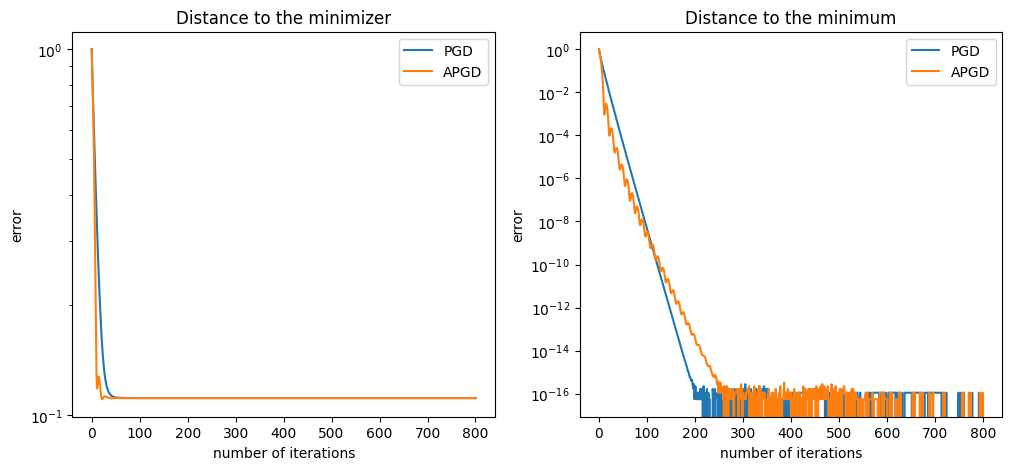

In [15]:
f, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(errors_PGD, label = "PGD")
axes[0].plot(errors_APGD, label = "APGD")
axes[0].set_xlabel("number of iterations")
axes[0].set_ylabel("error")
axes[0].set_yscale("log")
axes[0].set_title("Distance to the minimizer")
axes[0].legend()

axes[1].plot(objectives_PGD - objectives_PGD[-1], label = "PGD")
axes[1].plot(objectives_APGD - objectives_APGD[-1], label = "APGD")
axes[1].set_xlabel("number of iterations")
axes[1].set_ylabel("error")
axes[1].set_yscale("log")
axes[1].set_title("Distance to the minimum")
axes[1].legend()

plt.show()

We will first treat each of the above plots individually then we'll conclude with a comparison of the two algorithms : 
- Distance to the minimizer : 
    - PGD : The curve of the PDG algorithm is constantly decreasing and converges to the minimizer. This is consistent with the theory as the algorithm is guaranteed to converge to the minizer as explained in the course with the proximal gradient descent theorem :
    $$
    f(w^T) - f(w^*) \le \frac{L\Vert w^1 - w^* \Vert_2^2}{2T} = O\left(\frac{1}{T}\right) 
    $$
    - APGD : On the other hand, the APGD algorithm doesn't constantly decreases toward the minimum. If fact, it oscillates around the optimal solution and converges to it. This is consistent with the theory as the APGD algorithm explicited bellow : 
    $$
    f(w^T) - f(w^*) \le \frac{2L\Vert w^1 - w^* \Vert_2^2}{(T+1)^2} = O\left(\frac{1}{T^2}\right)
    $$
    - In addition we can denote that the convergence theorem for PDG guarantees a convergence in $O\left(\frac{1}{T}\right)$ while the APGD algorithm guarantees a convergence in $O\left(\frac{1}{T^2}\right)$. This is consistent with the plots as the APGD algorithm converges faster than the PDG algorithm towards the minimizer.

- Distance to the minimum :
    - PGD : The curve of the PDG algorithm is constantly decreasing and converges to the minimum. 
    - APGD : The APGD algorithm doesn't constantly decreases to the minimum but still converges with oscillations towards it.
    - Explanations are seemingly the same as the ones for the distance to the minimizer except one aspect. After a certain number of iterations (around 100), the PGD algorithm's distance to the minimum gets lower than the APGD one. This could be explained by the oscillations of the APGD algorithm that are not present in the PDG and cause the variations of distance to the minimum described in the plot.


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

#### Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.

First, let's study $L_1norm$ : 

In [16]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)

# L1 norm
x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)

x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_PGD, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_APGD, verbose=False)

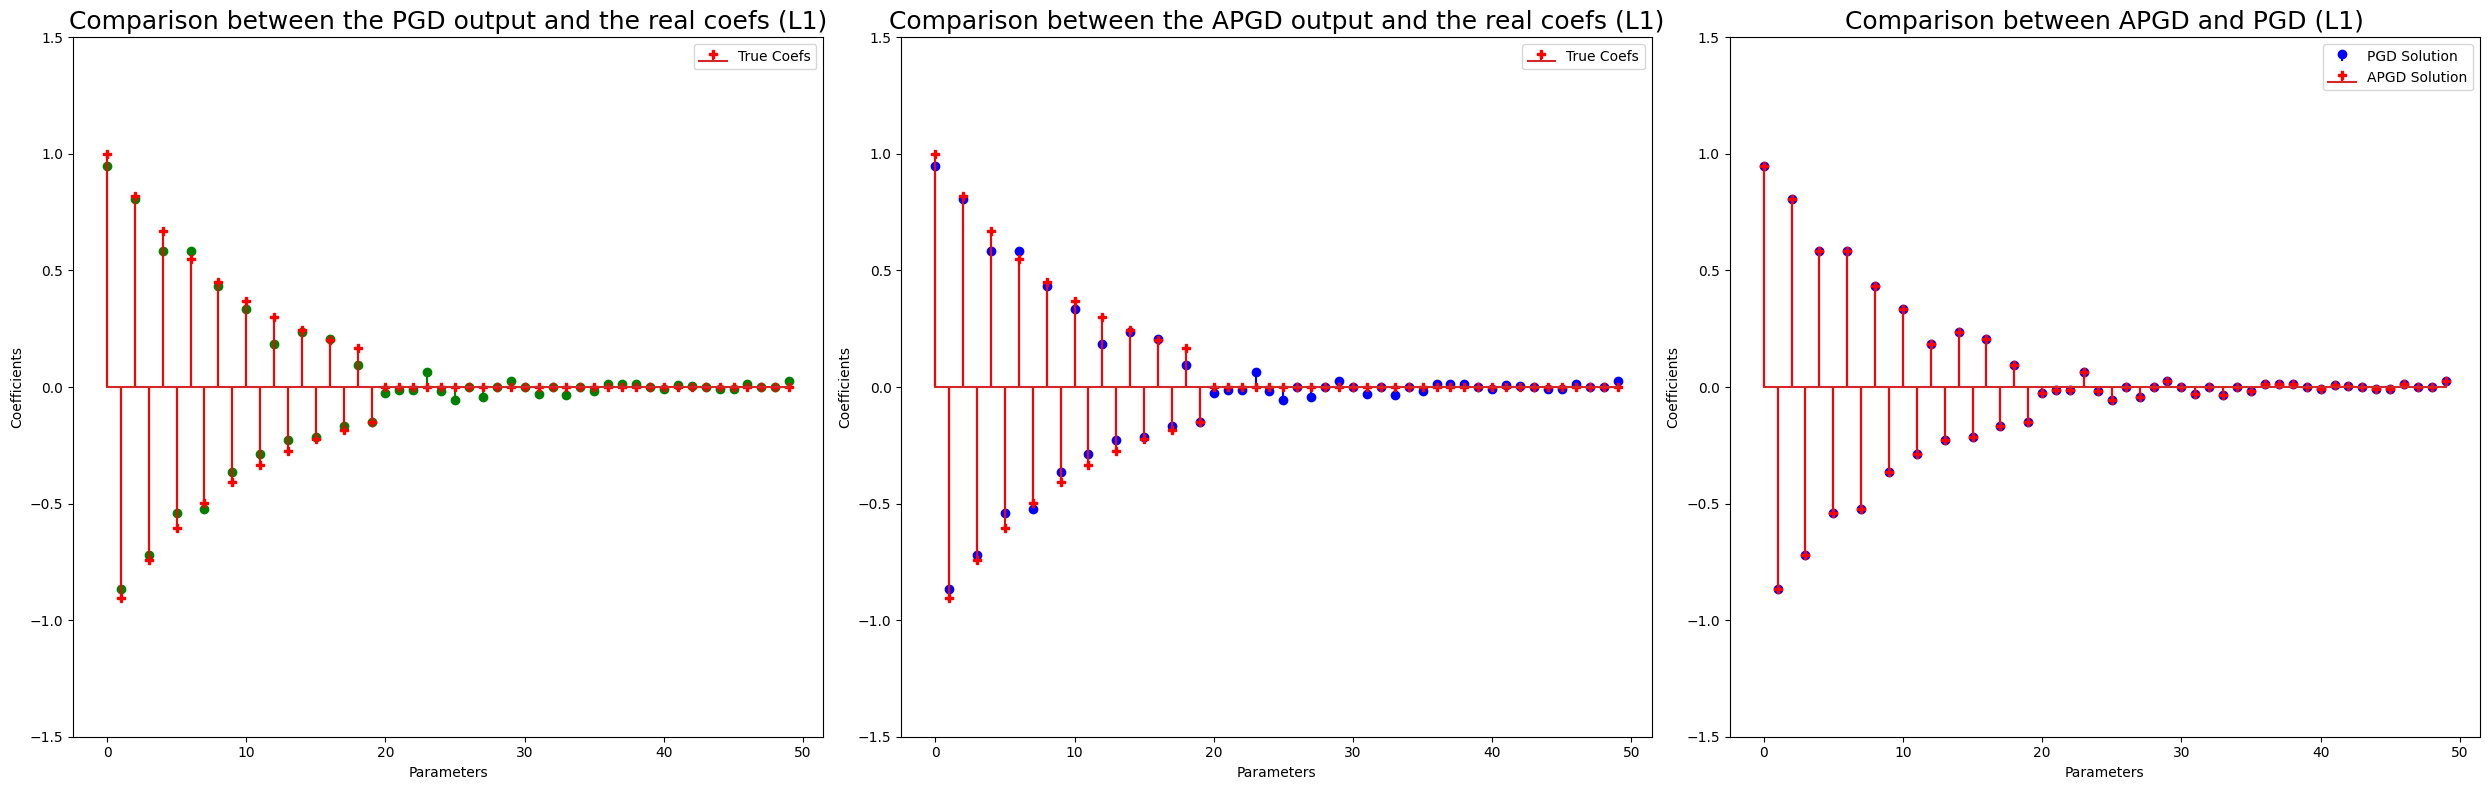

In [17]:
plt.figure(figsize=(25, 8))

#  solution obtained by PGD 
plt.subplot(1, 3, 1)
plt.stem(x_PGD, linefmt='g-', markerfmt='go', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the PGD output and the real coefs (L1)", fontsize=18)
plt.xlabel("Parameters")
plt.ylabel("Coefficients")
plt.ylim([-1.5, 1.5])
plt.legend()

# solution obtained by APGD 
plt.subplot(1, 3, 2)
plt.stem(x_APGD, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the APGD output and the real coefs (L1)", fontsize=18)
plt.xlabel("Parameters")
plt.ylabel("Coefficients")
plt.ylim([-1.5, 1.5])
plt.legend()

#comparison between APGD and PGD using plt.stem
plt.subplot(1, 3, 3)
plt.stem(x_PGD, linefmt='b-', markerfmt='bo', basefmt=' ', label='PGD Solution')
plt.stem(x_APGD, markerfmt='P', linefmt='red', label='APGD Solution')
plt.title("Comparison between APGD and PGD (L1)", fontsize=18)
plt.xlabel("Parameters")
plt.ylabel("Coefficients")
plt.ylim([-1.5, 1.5])
plt.legend()

# Show the plot
plt.tight_layout()

We can see that for both PGD or APGD we get results quite close to the real coefficients. On the last graph, we can see that we actually have the same results for PGD and APGD, since the blue and red points overlap perfectly.

Let's do the same for $L_2norm$ :

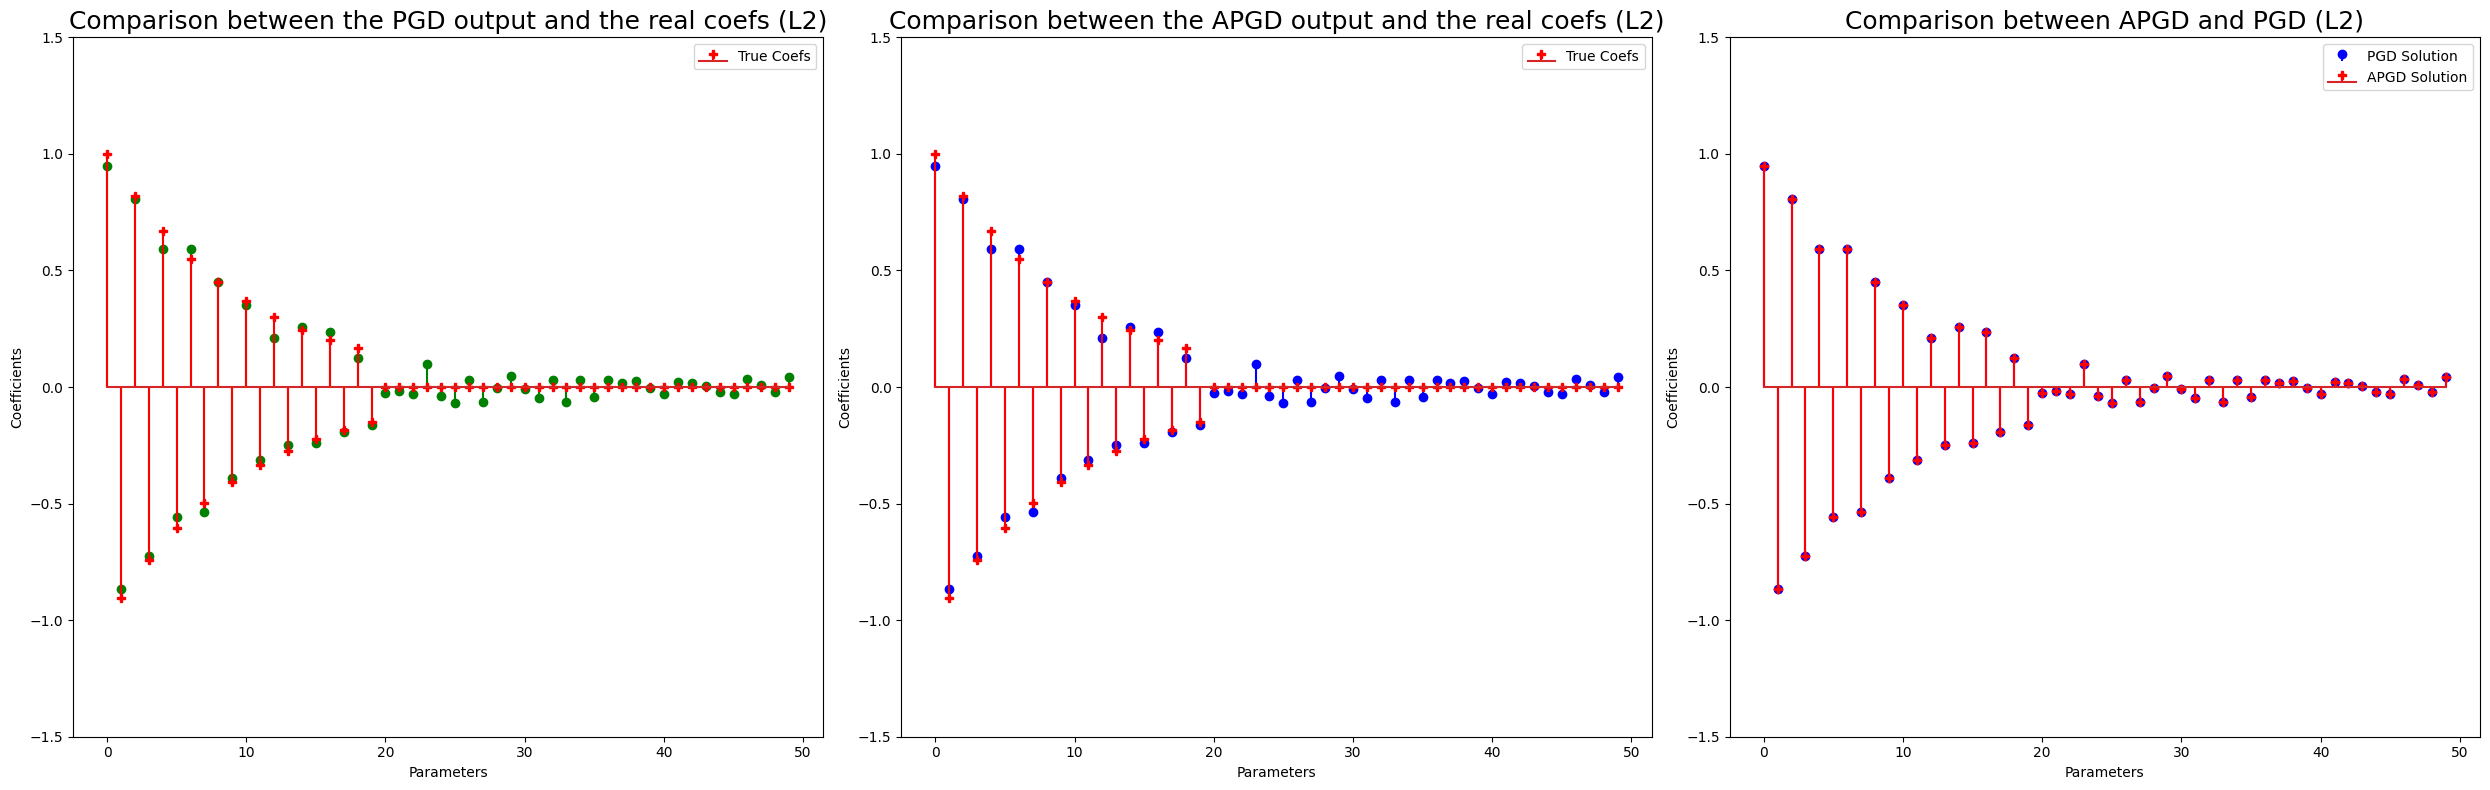

In [18]:
# L2 norm
x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)

x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_PGD, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_APGD, verbose=False)

plt.figure(figsize=(25, 8))

#  solution obtained by PGD 
plt.subplot(1, 3, 1)
plt.stem(x_PGD, linefmt='g-', markerfmt='go', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the PGD output and the real coefs (L2)", fontsize=18)
plt.xlabel("Parameters")
plt.ylabel("Coefficients")
plt.ylim([-1.5, 1.5])
plt.legend()

# solution obtained by APGD 
plt.subplot(1, 3, 2)
plt.stem(x_APGD, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the APGD output and the real coefs (L2)", fontsize=18)
plt.xlabel("Parameters")
plt.ylabel("Coefficients")
plt.ylim([-1.5, 1.5])
plt.legend()

#comparison between APGD and PGD using plt.stem
plt.subplot(1, 3, 3)
plt.stem(x_PGD, linefmt='b-', markerfmt='bo', basefmt=' ', label='PGD Solution')
plt.stem(x_APGD, markerfmt='P', linefmt='red', label='APGD Solution')
plt.title("Comparison between APGD and PGD (L2)", fontsize=18)
plt.xlabel("Parameters")
plt.ylabel("Coefficients")
plt.ylim([-1.5, 1.5])
plt.legend()

# Show the plot
plt.tight_layout()

We have very similar results.

#### Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.

Let's choose the logistic regression with L1 regularizer : 

In [19]:
cor=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

er_PGD=[]
er_APGD=[]

labels = []

for i in cor:
    A, b = simu_logreg(coefs, corr=np.round(i,1))
    L=smoothness_const_loreg(A)
    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)

    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_PGD, verbose=False)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_APGD, verbose=False)

    er_PGD.append(errors_PGD)
    er_APGD.append(errors_APGD)
    labels.append(f'Correlation {i}')

Now, we will plot the error with respect to the correlation with all the different correlations :

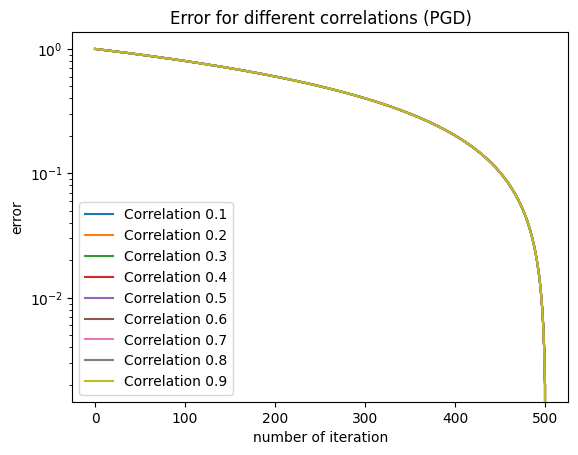

In [20]:
for i in range(len(er_PGD)):
     plt.plot(er_PGD[i], label = labels[i])
plt.xlabel("number of iteration")
plt.ylabel("error")
plt.yscale("log")
plt.title("Error for different correlations (PGD)")
plt.legend()
plt.show()

#### Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of penalization ( 𝜆 ) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when  𝜆  increases.

Now, we'll study linear regression with L2 regularization :

In [21]:
A,b=simu_linreg(coefs)
L=smoothness_const_linreg(A)

lambdas = np.arange(0.1, 1, 0.1)

er_PGD=[]
er_APGD=[]
labels = []

for i in lambdas:
    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500, verbose=False)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500, verbose=False)

    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500, x_true = x_PGD, verbose=False)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500, x_true = x_APGD, verbose=False)

    er_PGD.append(errors_PGD)
    er_APGD.append(errors_APGD)
    labels.append(f'Lambda {i}')

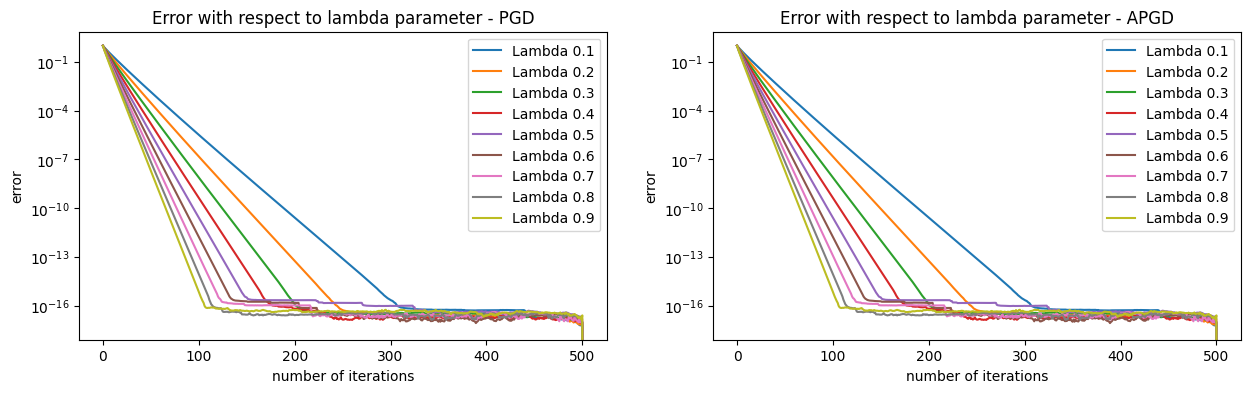

In [22]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
for i, e in enumerate(er_PGD):
    plt.plot(e, label = labels[i][:10])
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("error")
plt.yscale("log")
plt.title("Error with respect to lambda parameter - PGD")
plt.legend()

plt.subplot(1, 2, 2)
for i, e in enumerate(er_APGD):
    plt.plot(e, label = labels[i][:10])
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("error")
plt.yscale("log")
plt.title("Error with respect to lambda parameter - APGD")
plt.legend()

plt.show()

From the plots above we can conclude that the lambda parameter has a huge impact on the convergence speed for both PGD and APGD. Looking at the results : the higher $\lambda$ is, the faster the convergence will be. 